Inferindo Comportamento de usuários
======
`Vamos supor que temos dados da quantidade de compras de um determinado produto. Nós estamos interessados em saber se o comportamento do usuário mudou ao longo do tempo. `

___

Nesse notebook iremos utilizar dados simbólicos e códigos do livro bayesian modeling for hackers. Na versão do livro, os dados representam o comportamento de um usuário com relação a quantidade de mensagem de textos que envia. Apesar disso, podemos utilizar os conceitos aqui apresentados em qualquer tipo de modelagem onde os dados são contagens de eventos.


<br>

Vamos supor que os dados abaixo representam o comportamento de compras de um determinado cliente ao longo do tempo. No eixo y temos a quantidade compras e no eixo x os tempo ( dias ). Olhando para o gráfico abaixo, você seria capaz de dizer se houve alguma mudança de comportamento desse cliente? 




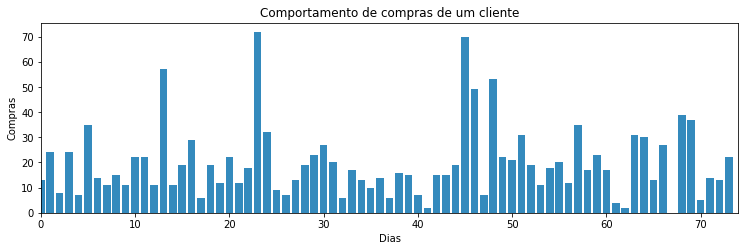

In [4]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Dias")
plt.ylabel("Compras")
plt.title("Comportamento de compras de um cliente")
plt.xlim(0, n_count_data);

## A modelagem

Vamos inicar nossa modelagem. Primeiramente, vamos lembrar que como vimos no notebook anterior -  [link do notebook](https://github.com/jmcabreira/Bayesian-Modeling/blob/main/Distribuicoes/Distribuicoes%20-%20Random%20Variables.ipynb) -
variáveis aleatórias de Poisson são apropriadas para modelar esse tipo de dados onde temos contagens de eventos. Denotando dia $i$'s e contagem de compras por $C_i$,


$$ C_i \sim \text{Poisson}(\lambda)  $$

Lembre-se que não sabemos o valor do parâmetro  $\lambda$. Quando olhamos para o gráfico acima, podemos notar, aparentemente, os valores de compras possuem uma tendencia a aumentar em algum ponto porém não sabemos onde e se esse aumento de fato ocorre. Dizer que é possível que haja essa tendência é o mesmo que dizer que o valor de  $\lambda$ aumenta em algum ponto do nosso range de observação. É importante salientar um valor maior de $\lambda$ atribui maior probabilidade a valores de compras maiores. Ou seja, nesse caso existe uma maior probabilidade de muitas compras terem sido feitas em um determinado dia.

Agora vamos representar essas observações matematicamente. Diante do que acabamos de discutir, vamos assumir que em um determinado período de observação desconhecido ( $\tau$ ), o parâmetro $\lambda$ variou para um valor maior. Dessa forma, teremos dois parâmetros $\lambda$ : um para o período menor que $\tau$ e outro para o resto das observações. Podemos também chamar $\tau$ de *switchpoint*:

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$


Talvez vc deva estar se perguntando : ué, e se não houver essa mudança que estamos supondo? Bom, nesse caso $\lambda_1 = \lambda_2$ o que implica que a distribuição posteriori dos $\lambda$s serão similares. 


Estamos interessados em inferir os $\lambda$s desconhecidos. Para modelar sob a perspectiva bayesiana, nós temos que atribuir probabilidades a priori ( prior probabilities ) para diferentes possíveis valores de $\lambda$. Lembre-se de que $\lambda$s pode ser qualquer valor positivo, e que a distribuição *exponencial* fornece uma função de densidade contínua para números positivos. Dessa forma, a *exponencial* parece ser uma boa escolha para modelar $\lambda$. Além disso, lembre-se que a distribuição exponencial carrega consigo um parâmetro próprio e nós temos que incluí-lo na nossa modelagem. Vamos chamar esse parâmetro de $\alpha$.

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}




$\alpha$ é um parâmetro que influencia em outro parâmetro e por isso é chamado de hiperparâmetro. Vamos assumir que o parâmetro $\alpha$ não possui grande influência na modelagem para termos um pouco mais de flexibilidade. Uma regra prática ( rule of thumb ) que podemos utilizar é definir o parâmetro exponencial igual ao inverso da média dos dados da observação. Como estamos modelando $\lambda$ utilizando a distribuição exponencial, podemos utilizar o seu esperado ( expected value ) :


$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 


Poderíamos também determinar duas distribuições a priori para $\lambda_i$ e consequentemente, determinar duas distribuições exponenciais com diferentes valores de $\alpha$. 

Com relação ao parâmetro $\tau$ (*switchpoint*), fica difícil apenas observando o plot em qual momento essa possível mudança ocorreu ( se é que ocorreu ). Por conta disso, vamos assumir uma distribuição de probabilidade uniforme para todos os possíveis dias como a priori. Em outras palavras : 

\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}

Após todas essas premissas ( que assumimos ) estaremos interessados em descrobrir a distribuição de probabilidade posteriori que descreve o comportamento do nosso cliente. Para isso, iremos utilizar PyMC3. Uma biblioteca python para performar Análise Bayesiana que irá nos ajudar em simplicar toda essa matemática que vimos e que iremos enfrentar nas nossas modelagens.


Lembre-se, que em nossa modelagem estaremos representando os componentes ($\tau, \lambda_1, \lambda_2$ ) como variáveis.

In [6]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

In [9]:
import pymc3 as pm

with pm.Model() as model:
    alpha =  1.0 / count_data.mean()  # count_data - > dados com compras do nosso cliente
    
    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    
    tau = pm.DiscreteUniform('tau', lower = 0 , upper = n_count_data - 1)

No código acima nós utilizamos PyMC3 para criar variáveis aleatórias que correspondem a $\lambda_1$ e $\lambda_2$. Essas variáveis são aleatórias no PyMC3 devido ao processo gerador das mesmas, que é aleatório.

In [11]:
with model:
    idx = np.arange(n_count_data) # index
    lambda_ = pm.math.switch(tau > idx , lambda_1, lambda_2)

Já no código acima, nós criamos uma função `lambda_` cujo pode ser pensada como uma variável aleatória. A função `switch()` atribui `lambda_1` ou `lambda_2` como valores para  `lambda_`, dependendo de qual lado do  `tau` estamos observando ( lembre-se que  `tau` é nosso switchpoint e que estamos considerando `lambda_`s diferentes ). 

Observe ainda que  `lambda_1`, `lambda_2` e `tau` são aleatórios, e por consequência,  `lambda_`  também o será. 



In [12]:
with model:
    observation = pm.Poisson("obs", lambda_, observed = count_data)

A variável `observation` combina nossos dados `count_data` com nosso esquema de geração de dados que foi proposto, dado pela nossa variável `lambda_` e pela chave `observed` da Poisson.

O código abaixo será melhor explicado nos próximos notebooks, logo, a princípio não vamos dar muitos detalhes a respeito. Apesar disso, podemos entender essa etapa como um processo de aprendizagem. O que estamos utilizando aqui é *Markov Chain Monte Carlo* (MCMC) que também será melhor detalhado posteriormente. Essa técnica nos da milhares de variáveis aleatórias das distribuições de probabilidades posteriori de $\lambda_1, \lambda_2$ e $\tau$. 

Iremos em seguida plotar as distribuições de provbabilidades dessas variáveis para observa-las. Abaixo, nós coletamos amostras ( conhecidas como *traces* na literatura de MCMC ) em histogramas.


In [14]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune = 5000, step = step, return_inferencedata = False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 525 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [15]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

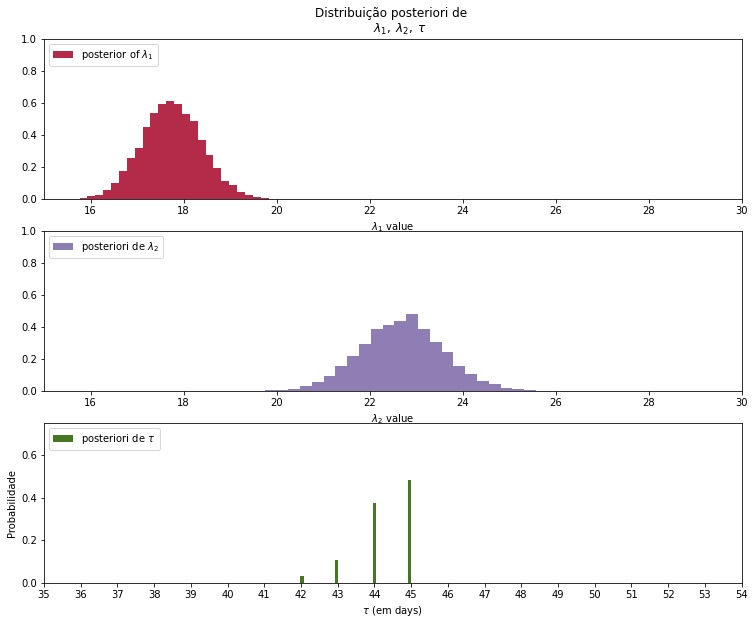

In [16]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Distribuição posteriori de 
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posteriori de $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posteriori de $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (em days)")
plt.ylabel("Probabilidade");

## Como interpretamos os resultados ?